In [1]:
%matplotlib nbagg
%matplotlib inline
import MDAnalysis as mda
import MDAnalysis.analysis.leaflet
import matplotlib
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import nglview as nv
import copy
import warnings
warnings.filterwarnings('ignore')

# indicate the name of the simulation, the path of the data and the .gro and .xtc files to import
# no GM1

name = '_DPPC_DIPC_chol_352'

path = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol/'
pathd = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol/dynamics/'

fgro = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1.xtc'

# indicate the name of the simulation, the path of the data and the .gro and .xtc files to import
# 5% GM1

name = '_DPPC_DIPC_chol_352_5GM1_sup'

path_data = '/mnt/modelo-nfs/data/Julie/DPPC_DIPC_GM1/3_5_2/DIPC_DPPC_chol_GM1_5/'
path_res = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol_GM1_5/'
pathd = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol_GM1_5/dynamics/'

fgro = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_20micros_mb_fixed_t1_ref19999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_20micros_mb_fixed_t1.xtc'

In [31]:
# indicate the name of the simulation, the path of the data and the .gro and .xtc files to import
# 10% GM1

name = '_DPPC_DIPC_chol_352_10GM1_sup'

path_data = '/mnt/modelo-nfs/data/Julie/DPPC_DIPC_GM1/3_5_2/DIPC_DPPC_chol_GM1_10/'
path_res = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol_GM1_10/'
pathd = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol_GM1_10/dynamics/'

fgro = 'run_DPPC_DIPC_CHOL_GM1_10_43nm_20micros_mb_fixed_t1_ref19999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_10_43nm_20micros_mb_fixed_t1.xtc'

# indicate the name of the simulation, the path of the data and the .gro and .xtc files to import
# 20% GM1

name = '_DPPC_DIPC_chol_352_20GM1'

path = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol_GM1_20/'

fgro = 'run_DPPC_DIPC_CHOL_GM1_20_43nm_10ms_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_20_43nm_10ms_mb_fixed_t1.xtc'

# name and files for the simulation studied LPT - no GM1

name = '_DPPC_DIPC_chol_352'

path = '/users/cornet/Documents/PhD/Matthieu/3-5-2/sans_GM1/'

fgro = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1.xtc'

# name and files for the simulation studied LPT - 5% GM1

name = '_DPPC_DIPC_chol_352_5GM1'

path = '/users/cornet/Documents/PhD/Matthieu/3-5-2/5_GM1/'
pathd = '/users/cornet/Documents/PhD/Matthieu/3-5-2/5_GM1/dynamics/'

fgro = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1.xtc'

# name and files for the simulation studied LPT - 10% GM1

name = '_DPPC_DIPC_chol_352_10GM1'

path = '/users/cornet/Documents/PhD/Matthieu/3-5-2/10_GM1/'
pathd = '/users/cornet/Documents/PhD/Matthieu/3-5-2/10_GM1/dynamics/'

fgro = 'run_DPPC_DIPC_CHOL_GM1_10_43nm_10ms_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_10_43nm_10ms_mb_fixed_t1.xtc'

In [32]:
# load gro and xtc files
u = mda.Universe( path_data+fgro, path_data+fxtc)

In [33]:
sel_all = u.select_atoms("all")

In [34]:
# visualize the bilayer and choose the frame to study

v= nv.show_mdanalysis(sel_all, gui=True)
#v.frame = 6395
v.add_spacefill(sel_all, scale=2.0)
v

A Jupyter Widget

A Jupyter Widget

In [46]:
#v.download_image(filename='screenshot.png', factor=4, antialias=True, trim=False, transparent=False)

# boucle pour travailler sur des frames de la simu

tmes = 400

str_sel= "all and (name PO4 or name GM1)"

            
Lf = mda.analysis.leaflet.LeafletFinder(u, 'name PO4 or name GM1')
leaflet0 = Lf.groups(0)
leaflet1 = Lf.groups(1)
            
for ts in u.trajectory:
     if (ts.frame%tmes == 0 and ts.frame>=t_start and ts.frame==6400):
            print(ts.frame)
            
            patch = u.select_atoms(str_sel).positions
            
            Lo = leaflet1.select_atoms("(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and name PO4 and resname DPPC").positions
            Ld = leaflet1.select_atoms("(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and name PO4 and resname DIPC").positions
            GM1 = leaflet1.select_atoms("(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and name AM1").positions
            chol = leaflet1.select_atoms("(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and name ROH").positions

            xmax = max(patch[:,0])
            ymax = max(patch[:,1])
            
            xmin = min(patch[:,0])
            ymin = min(patch[:,1])
            
            N = 15
            dx = (xmax-xmin)/N
            dy = (ymax-ymin)/N
            plt.scatter(Lo[:,1]/N, -Lo[:,0]/N, marker='.', c='yellow', s=2)
            plt.scatter(Ld[:,1]/N, -Ld[:,0]/N, marker='.', c='b', s=2)
            plt.scatter(GM1[:,1]/N, -GM1[:,0]/N, marker='+', c='g', s=2)
            plt.savefig(pathd+'t'+str(ts.frame)+'.pdf', format='pdf',bbox_inches='tight')
            #pour enregistrer les plots


In [35]:
# needed functions for the local curvature computation

def F_neigh(n) :
    neigh[0] = n
    i=n%N
    j=int(n/N)
    ip1=(i+1)%N
    im1=(i-1)%N
    jp1=(j+1)%N
    jm1=(j-1)%N
    neigh[1] = ip1+N*j
    neigh[2] = im1+N*j
    neigh[3] = i+N*jm1
    neigh[4] = i+N*jp1

def Lap(n) :
    lap = ( h[neigh[4]]+h[neigh[3]]-2*h[neigh[0]] ) / dx**2 + ( h[neigh[1]]+h[neigh[2]]-2*h[neigh[0]] ) / dy**2
    return(lap)


In [47]:
time_simu = 20 # microseconds
nb_frames_simu = 20000

In [37]:
# Leaflet separation

u.trajectory[2]
Lf = mda.analysis.leaflet.LeafletFinder(u, 'name PO4 or name GM1')
leaflet0 = Lf.groups(0)
leaflet1 = Lf.groups(1)

sel_tot = "all and (name PO4 or name GM1)"
l0 = leaflet0.select_atoms(sel_tot).positions
l1 = leaflet1.select_atoms(sel_tot).positions
m_tot = u.select_atoms(sel_tot).positions

print('total number of lipids: %d' % len(m_tot))
print('number of lipids in the upper leaflet: %d + number of lipids in the lower leaflet:%d \n= %d' % (len(l0),len(l1),len(l0)+len(l1)))

if (len(m_tot) != len(l0)+len(l1) ):
    print('PROBLEM!')

total number of lipids: 5272
number of lipids in the upper leaflet: 2676 + number of lipids in the lower leaflet:2596 
= 5272


In [38]:
#loop to compute all the observables through time


tmes = 50
t_start = 5000

N = 15
threshold = 0.6 # composition threshold from which the box is considered Lo, below it is considered Ld

t = []

C_t_Lo = []
C_t_Ld = []
C_t_bound_Lo = []

thick_t_Lo = []
thick_t_Ld = []

rate_GM1_Lo_t = []
rate_GM1_bound_Lo_t = []
rate_GM1_Ld_t = []

cov_phi_t = []
cov_e_t = []
cov_c_t = []


for ts in u.trajectory:
    
    # boxes that do not contain any PC molecule
    empty0 = 0
    empty1 = 0
    
    if (ts.frame%tmes == 0 and ts.frame>=t_start):
            
            print(ts.frame)
            t.append(ts.frame/ (nb_frames_simu/time_simu))
            
            patch = u.select_atoms(sel_tot).positions
   
            GM1 = u.select_atoms("all and name GM1").positions
            # to know if there are GM1 or not
            if(len(GM1)==0 and ts.frame==t_start):
                print('No GM1')
            
            xmax = max(patch[:,0])
            ymax = max(patch[:,1])
            
            xmin = min(patch[:,0])
            ymin = min(patch[:,1])
            
            
            dx = (xmax-xmin)/N
            dy = (ymax-ymin)/N
           
            
            # leaflet 0 -----------------------------------------------------------------------------------------------------
            
            bary0 = []

            Mphi0_Lo = np.zeros((N,N)) # ratio DPPC / all PC in each box
            M_nb_GM1 = np.zeros((N,N)) # number of GM1 molecules in each box

            for i in range(0,N):
                xs = xmin + i*dx
                for j in range(0,N):
                    ys = ymin + j*dy

                    # barycenter of all molecules in each box
                    sel= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+")"
                    b0=leaflet0.select_atoms(sel).centroid().tolist()
                    bary0.append(b0)

                    # PC composition rates in each box
                    sel_totPC= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+" and name PO4)"
                    tot0PC= leaflet0.select_atoms(sel_totPC).positions
                    n_tot0PC=len(tot0PC) # total number of PC

                    sel_Lo= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and resname DPPC"
                    Lo0= leaflet0.select_atoms(sel_Lo).positions
                    n_Lo0=len(Lo0) # number of molecules of the Lo phase (DPPC here)
                    
                    if  n_tot0PC!=0:
                        phi0_Lo=n_Lo0/n_tot0PC
                        Mphi0_Lo[i,j]=phi0_Lo
                    else :
                        empty0 += 1
                        print('leaflet 0, empty box: i=%d and j=%d' % (i,j))
                    
                    if(len(GM1)!=0):
                        # GM1 rates in each box        
                        sel_GM1= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and name GM1"
                        GM1_0= leaflet0.select_atoms(sel_GM1).positions
                        n_GM1_0=len(GM1_0) # number of GM1 molecules        

                        M_nb_GM1[i,j]=n_GM1_0


            bary0=np.array(bary0)
            
            # leaflet 1 -----------------------------------------------------------------------------------------------------
            
            bary1 = []

            Mphi1_Lo = np.zeros((N,N))

            for i in range(0,N):
                xs = xmin + i*dx
                for j in range(0,N):
                    ys = ymin + j*dy

                    # barycenter of all molecules in each box
                    sel= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+")"
                    b1=leaflet1.select_atoms(sel).centroid().tolist()
                    bary1.append(b1)

                    # composition rates in each box
                    sel_totPC= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+" and name PO4)"
                    tot1PC= leaflet1.select_atoms(sel_totPC).positions
                    n_tot1PC=len(tot1PC) # total number of PC

                    sel_Lo= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and resname DPPC"
                    Lo1= leaflet1.select_atoms(sel_Lo).positions
                    n_Lo1=len(Lo1) # number of molecules of the Lo phase (DPPC here)

                    if  n_tot1PC!=0:
                        
                        phi1_Lo=n_Lo1/n_tot1PC
                        Mphi1_Lo[i,j]=phi1_Lo
                    else :
                        empty1 += 1
                        print('leaflet 1,empty box: i=%d and j=%d' % (i,j))


            bary1=np.array(bary1)
            #--------------------------------------------------------------------------------------------------------------------------------
            
            # mean (between the 2 leaflets) composition field
            Mphi_mean = (Mphi0_Lo+Mphi1_Lo)/2
            
##################################################################################################################################  
            # compute the local thickness
    
            bary0.shape=(N,N,3)
            bary1.shape=(N,N,3)

            diffz=bary0[:,:,2]-bary1[:,:,2]

            bary0.shape=(N*N,3)
            bary1.shape=(N*N,3)
            
##################################################################################################################################  
            # compute the local curvature
            
            neigh = [0,0,0,0,0]
            h=bary0[:,2]         # for the upper leaflet
            laplacian = []
            
            for i in range(N*N) :
                F_neigh(i)
                laplacian.append(Lap(i))
                
            C = np.array(laplacian)
            C.shape=(N,N)

##################################################################################################################################  
            # binary composition and local thickness and curvature associated to Lo phase and Lo boundary
# LEAFLET 0       
            # Lo phase binarization
            Mphi0_bin = np.zeros((N,N))

            for i in range(N):
                for j in range(N):
                    if Mphi0_Lo[i,j]>= threshold :
                        Mphi0_bin[i,j]=1
# LEAFLET 1       
            # Lo phase binarization
            Mphi1_bin = np.zeros((N,N))

            for i in range(N):
                for j in range(N):
                    if Mphi1_Lo[i,j]>= threshold :
                        Mphi1_bin[i,j]=1
                        
# MEAN LEAFLET        
            # Lo phase binarization
            Mphi_mean_bin = np.zeros((N,N))

            for i in range(N):
                for j in range(N):
                    if Mphi_mean[i,j]>= threshold :
                        Mphi_mean_bin[i,j]=1        
                                            
# LEAFLET 0 only

            # Lo boundary determination
            Mphi0_bin.shape=(N*N)
            M_bound_Lo = np.zeros((N*N))
            neigh = [0,0,0,0,0]
            for i in range(N*N) :
                F_neigh(i)
                if Mphi0_bin[i]==1 and (Mphi0_bin[i]!=Mphi0_bin[neigh[1]] or Mphi0_bin[i]!=Mphi0_bin[neigh[2]] or Mphi0_bin[i]!=Mphi0_bin[neigh[3]] or Mphi0_bin[i]!=Mphi0_bin[neigh[4]]):
                    M_bound_Lo[i]=1
            M_bound_Lo.shape=(N,N)
            Mphi0_bin.shape=(N,N)
            
            # area ratio Lo / tot
            area_ratio_Lo = np.sum(Mphi0_bin)/(N*N)
            # area ratio Lo boundary / tot
            area_ratio_Lobound = np.sum(M_bound_Lo)/(N*N)
            # area ratio Ld / tot
            area_ratio_Ld = np.sum(1-Mphi0_bin)/(N*N)
            
##################################################################################################################################  
            # if the phase of the box is Lo then the thickness is averaged
            thick_Lo = []
            thick_Ld = []
            for i in range(N):
                for j in range(N):
                    if Mphi0_bin[i,j] == 1 :
                        thick_Lo.append(diffz[i,j])
                    else:
                        thick_Ld.append(diffz[i,j])
                        
            thick_t_Lo.append(np.mean(thick_Lo))
            thick_t_Ld.append(np.mean(thick_Ld))
            
            # if the phase of the box is Lo or Lo boundary then the curvature is averaged
            C_Lo = []
            C_Ld = []
            C_bound_Lo = []
            for i in range(N):
                for j in range(N):
                    if Mphi0_bin[i,j] == 1 :
                        C_Lo.append(C[i,j])
                    else:
                        C_Ld.append(C[i,j])
                    
                    if M_bound_Lo[i,j] == 1 :
                        C_bound_Lo.append(C[i,j])
                        
            C_t_Lo.append(np.mean(C_Lo))
            C_t_Ld.append(np.mean(C_Ld))
            C_t_bound_Lo.append(np.mean(C_bound_Lo))
            
##################################################################################################################################  
            if(len(GM1)!=0):
                # GM1 repartition
                nb_GM1_tot = np.sum(M_nb_GM1)

                # in the Lo phase
                M_GM1_Lo = Mphi0_bin*M_nb_GM1
                nb_GM1_Lo = np.sum(M_GM1_Lo)
                rate_GM1_Lo = nb_GM1_Lo/nb_GM1_tot

                rate_GM1_Lo_t.append(rate_GM1_Lo/area_ratio_Lo)

                # at the Lo boundary
                M_GM1_bound_Lo = M_bound_Lo*M_nb_GM1
                nb_GM1_bound_Lo = np.sum(M_GM1_bound_Lo)
                rate_GM1_bound_Lo = nb_GM1_bound_Lo/nb_GM1_tot

                rate_GM1_bound_Lo_t.append(rate_GM1_bound_Lo/area_ratio_Lobound)
                
                # in the Ld phase
                M_GM1_Ld = (1-Mphi0_bin)*M_nb_GM1
                nb_GM1_Ld = np.sum(M_GM1_Ld)
                rate_GM1_Ld = nb_GM1_Ld/nb_GM1_tot
                
                rate_GM1_Ld_t.append(rate_GM1_Ld/area_ratio_Ld)
    
##################################################################################################################################  
            # compute the correlations (covariance) 
            
            # composition of the 2 leaflets
            sum = 0
            for i in range(0,N):
                for j in range(0,N):
                    sum = sum + ( Mphi0_bin[i,j]*Mphi1_bin[i,j] - np.mean(Mphi0_bin)*np.mean(Mphi1_bin) ) / np.std(Mphi0_bin)/np.std(Mphi1_bin)
            cov_phi = sum/N**2
            cov_phi_t.append(cov_phi)
    
            # composition and local thickness (of the mean composition between the 2 leaflets)           
            sum = 0
            for i in range(0,N):
                for j in range(0,N):
                    sum = sum + ( Mphi_mean_bin[i,j]*diffz[i,j] - np.mean(Mphi_mean_bin)*np.mean(diffz) ) / np.std(Mphi_mean_bin)/np.std(diffz)
            cov_e = sum/N**2
            cov_e_t.append(cov_e)
            
            # composition and local curvature (of the upper leaflet)
            sum = 0
            for i in range(0,N):
                for j in range(0,N):
                    sum = sum + ( C[i,j]*Mphi0_bin[i,j] - np.mean(C)*np.mean(Mphi0_bin) ) / np.std(C)/np.std(Mphi0_bin)
            cov_c = sum/N**2
            cov_c_t.append(cov_c)
                       
##################################################################################################################################  
            # plot                        
            s = 10 # fontsize
            plt.subplot(221)
            plt.imshow(Mphi0_Lo)
            plt.colorbar()
            plt.title('Composition (DPPC ratio, upper leaflet)', fontsize=s)
            plt.subplot(222)
            plt.imshow(diffz)
            plt.colorbar()
            plt.title('Local thickness ($\AA$)', fontsize=s)
            plt.subplot(223)
            plt.imshow(Mphi0_bin)
            plt.colorbar()
            plt.title('Upper leaflet binary composition \n(1 is Lo, 0 is Ld)', fontsize=s)
            plt.subplot(224)
            plt.imshow(-C)
            plt.colorbar()
            plt.title('Upper leaflet local curvature ($\AA^{-1}$)', fontsize=s)
            plt.subplots_adjust(bottom=0.1, right=0.9, top=0.9, hspace = 0.5)
            plt.savefig(pathd+'compo-thick_Lo_curv'+name+'_t'+str(ts.frame)+'.pdf', format='pdf',bbox_inches='tight')
            plt.clf()
            
            print('empty boxes leaflet 0: %d' % empty0)
            print('empty boxes leaflet 1: %d' % empty1)

5000
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
5050
leaflet 0, empty box: i=4 and j=1
empty boxes leaflet 0: 1
empty boxes leaflet 1: 0
5100
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
5150
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
5200
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
5250
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
5300
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
5350
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
5400
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
5450
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
5500
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
5550
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
5600
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
5650
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
5700
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
5750
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
5800
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
5850
empty boxes leaflet 0: 0
e

12300
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
12350
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
12400
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
12450
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
12500
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
12550
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
12600
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
12650
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
12700
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
12750
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
12800
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
12850
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
12900
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
12950
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
13000
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
13050
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
13100
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
13150
empty boxes leaflet 0: 0
empty boxes leafl

19600
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
19650
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
19700
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
19750
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
19800
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
19850
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
19900
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
19950
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0


<Figure size 432x288 with 0 Axes>

In [48]:
t_start = t_start / (nb_frames_simu/time_simu)
tmes = tmes / (nb_frames_simu/time_simu)

In [53]:
xprint = t_start+(max(t)-t_start)/2

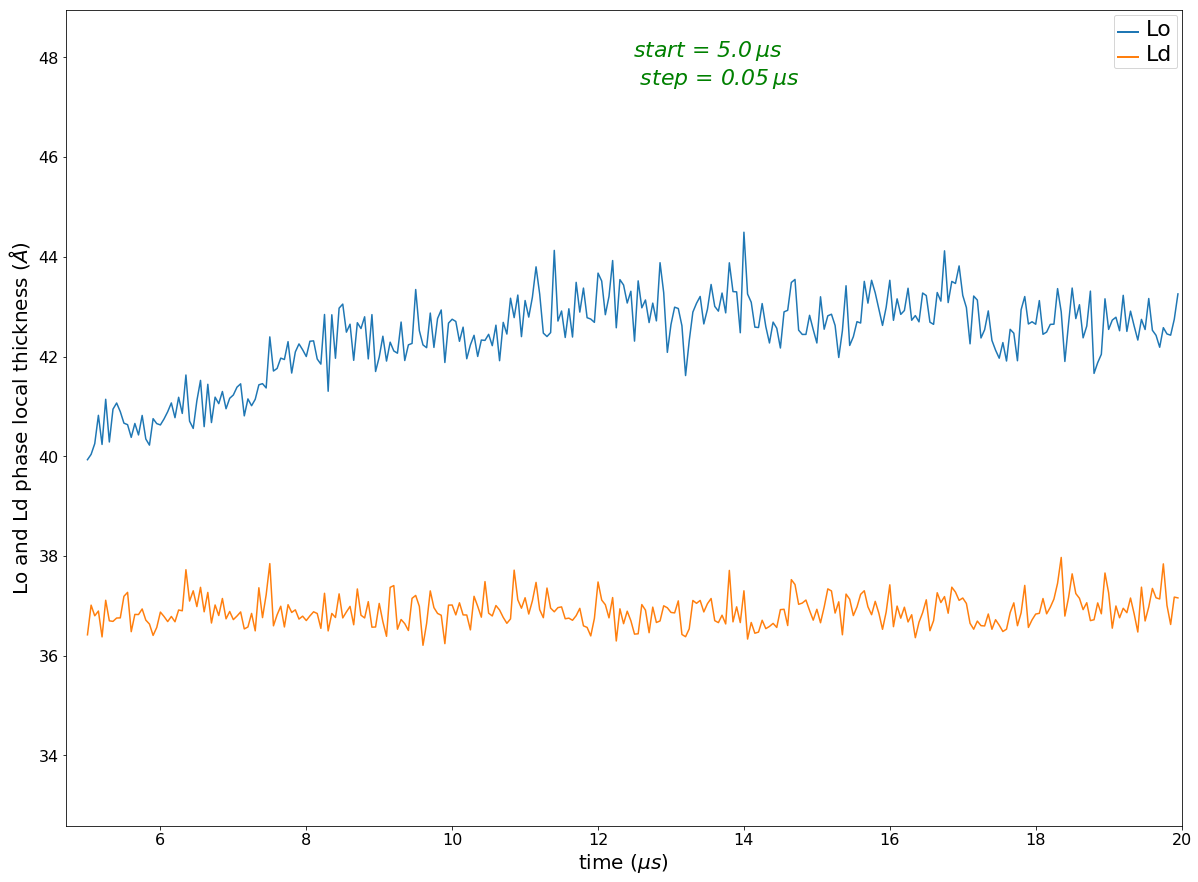

In [54]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(t, thick_t_Lo, label = 'Lo')
ax.plot(t, thick_t_Ld, label = 'Ld')

xmin = t_start-0.3
xmax = time_simu
ytop = max(max(thick_t_Lo, thick_t_Ld)) + max(max(thick_t_Lo, thick_t_Ld))/10
ymin = min(min(thick_t_Lo, thick_t_Ld)) - min(min(thick_t_Lo, thick_t_Ld))/10
yprint = max(max(thick_t_Lo, thick_t_Ld)) + max(max(thick_t_Lo, thick_t_Ld))/15

plt.xlabel('time ($\mu s$)',fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Lo and Ld phase local thickness ($\AA$)',fontsize=20)
plt.yticks(fontsize=16)
plt.annotate('start = %.1lf$\, \mu s$\n step = %.2lf$\, \mu s$' % (t_start, tmes), color='g', fontsize=22, style='italic', xy=(xprint,yprint), xytext=(xprint,yprint))

legend = ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
#frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize(22)
for label in legend.get_lines():
    label.set_linewidth(2)  # the legend line width


plt.xlim(xmin,xmax)
plt.ylim(ymin,ytop)
#plt.grid(True)

plt.savefig(pathd+'thickness_time'+name+'.pdf', format='pdf',bbox_inches='tight')

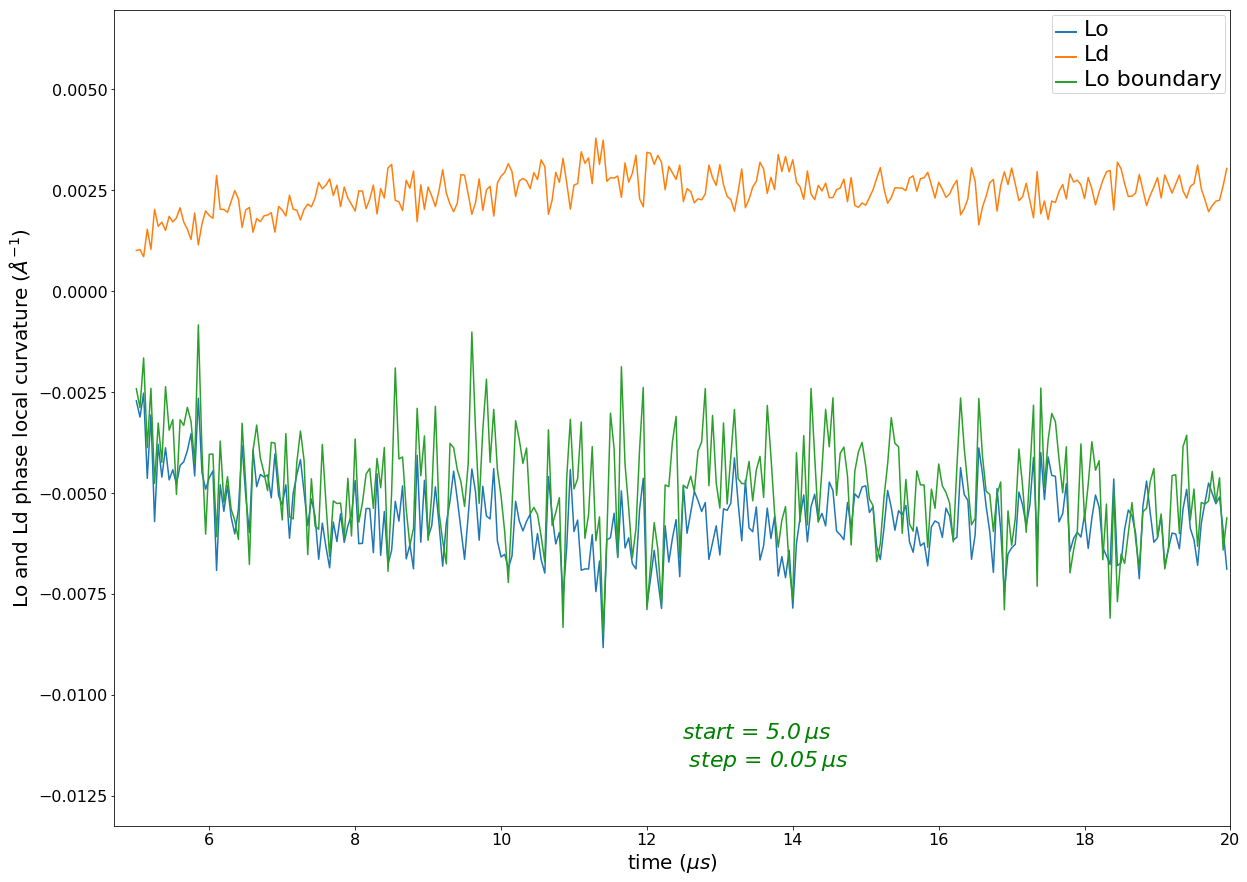

In [55]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(t, C_t_Lo, label = 'Lo')
ax.plot(t, C_t_Ld, label = 'Ld')
ax.plot(t, C_t_bound_Lo, label = 'Lo boundary')

ytop = max(max(C_t_Lo, C_t_Ld,C_t_bound_Lo)) + max(max(C_t_Lo, C_t_Ld,C_t_bound_Lo))/1.2
ymin = min(min(C_t_Lo, C_t_Ld)) + min(min(C_t_Lo, C_t_Ld))/2
yprint = min(min(C_t_Lo, C_t_Ld)) + min(min(C_t_Lo, C_t_Ld))/3

plt.xlabel('time ($\mu s$)',fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Lo and Ld phase local curvature ($\AA^{-1}$)',fontsize=20)
plt.yticks(fontsize=16)
plt.annotate('start = %.1lf$\, \mu s$\n step = %.2lf$\, \mu s$' % (t_start, tmes), color='g', fontsize=22, style='italic', xy=(xprint,yprint), xytext=(xprint,yprint))

legend = ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
#frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize(22)
for label in legend.get_lines():
    label.set_linewidth(2)  # the legend line width

xmin = t_start-0.3
xmax = time_simu
plt.xlim(xmin,xmax)
plt.ylim(ymin,ytop)
#plt.grid(True)

plt.savefig(pathd+'curvature_time'+name+'.pdf', format='pdf',bbox_inches='tight')

In [56]:
xprint = min(t)+(max(t)-min(t))/10

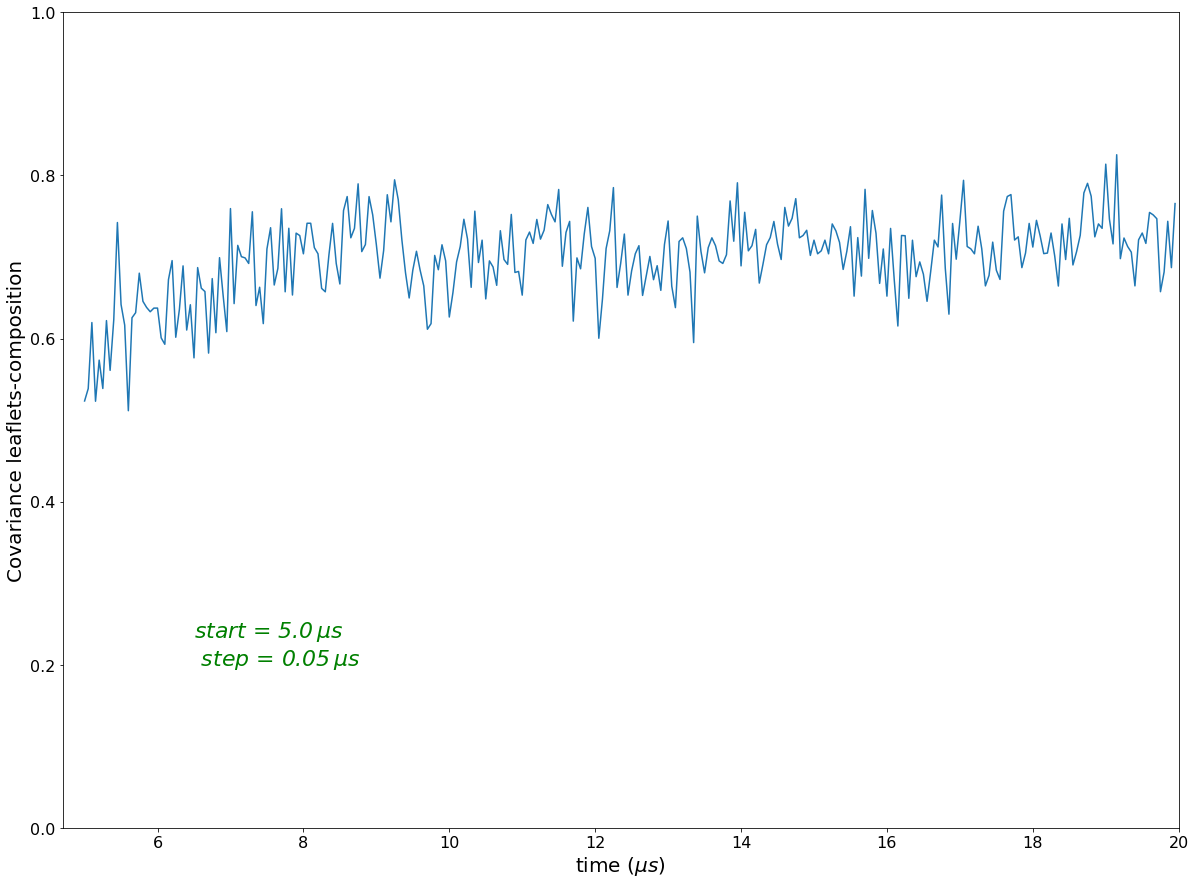

In [57]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(t, cov_phi_t)

yprint = 0.2

plt.xlabel('time ($\mu s$)',fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Covariance leaflets-composition',fontsize=20)
plt.yticks(fontsize=16)
plt.annotate('start = %.1lf$\, \mu s$\n step = %.2lf$\, \mu s$' % (t_start, tmes), color='g', fontsize=22, style='italic', xy=(xprint,yprint), xytext=(xprint,yprint))

xmin = t_start-0.3
xmax = time_simu
plt.xlim(xmin,xmax)
plt.ylim(0,1)

plt.savefig(pathd+'cov_phi_time_bin'+name+'.pdf', format='pdf',bbox_inches='tight')

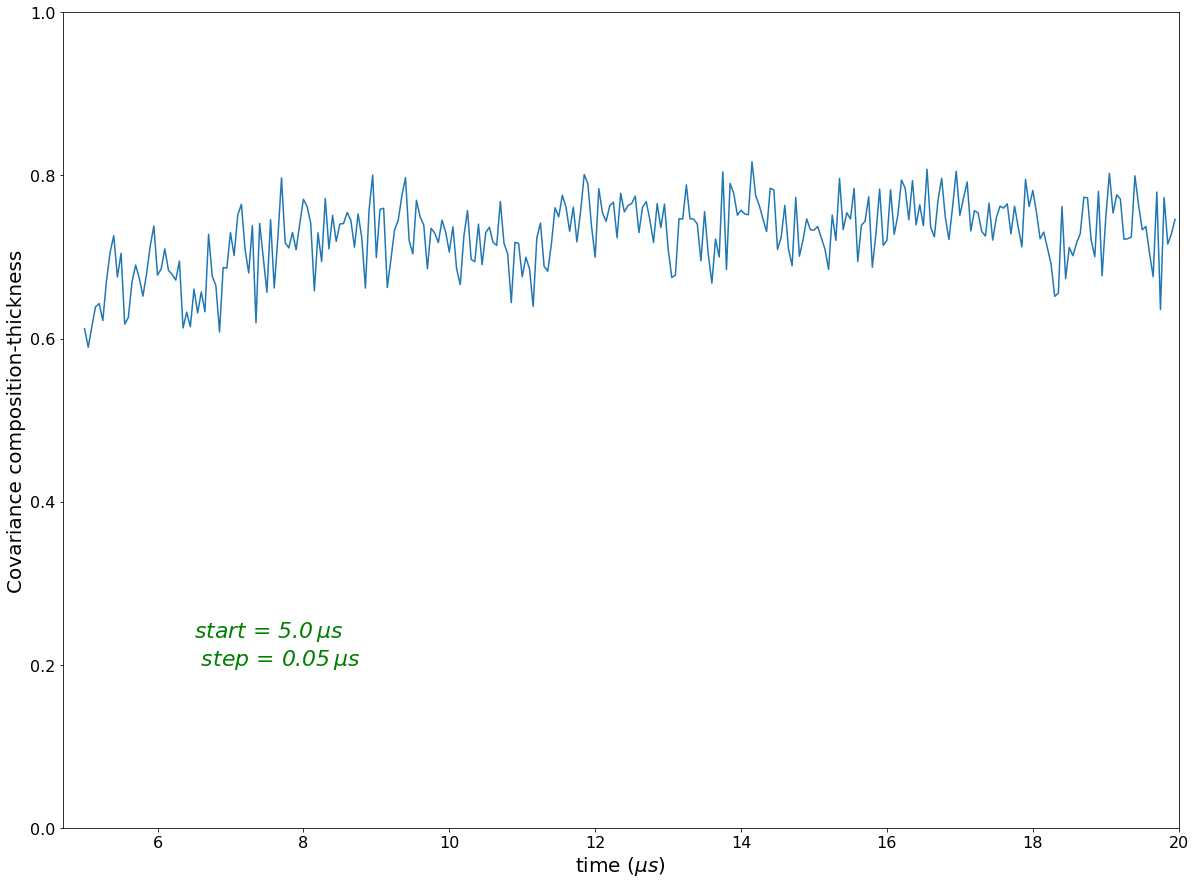

In [58]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(t, cov_e_t)

yprint = 0.2

plt.xlabel('time ($\mu s$)',fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Covariance composition-thickness',fontsize=20)
plt.yticks(fontsize=16)
plt.annotate('start = %.1lf$\, \mu s$\n step = %.2lf$\, \mu s$' % (t_start, tmes), color='g', fontsize=22, style='italic', xy=(xprint,yprint), xytext=(xprint,yprint))

xmin = t_start-0.3
xmax = time_simu
plt.xlim(xmin,xmax)
plt.ylim(0,1)

plt.savefig(pathd+'cov_e_time_bin'+name+'.pdf', format='pdf',bbox_inches='tight')

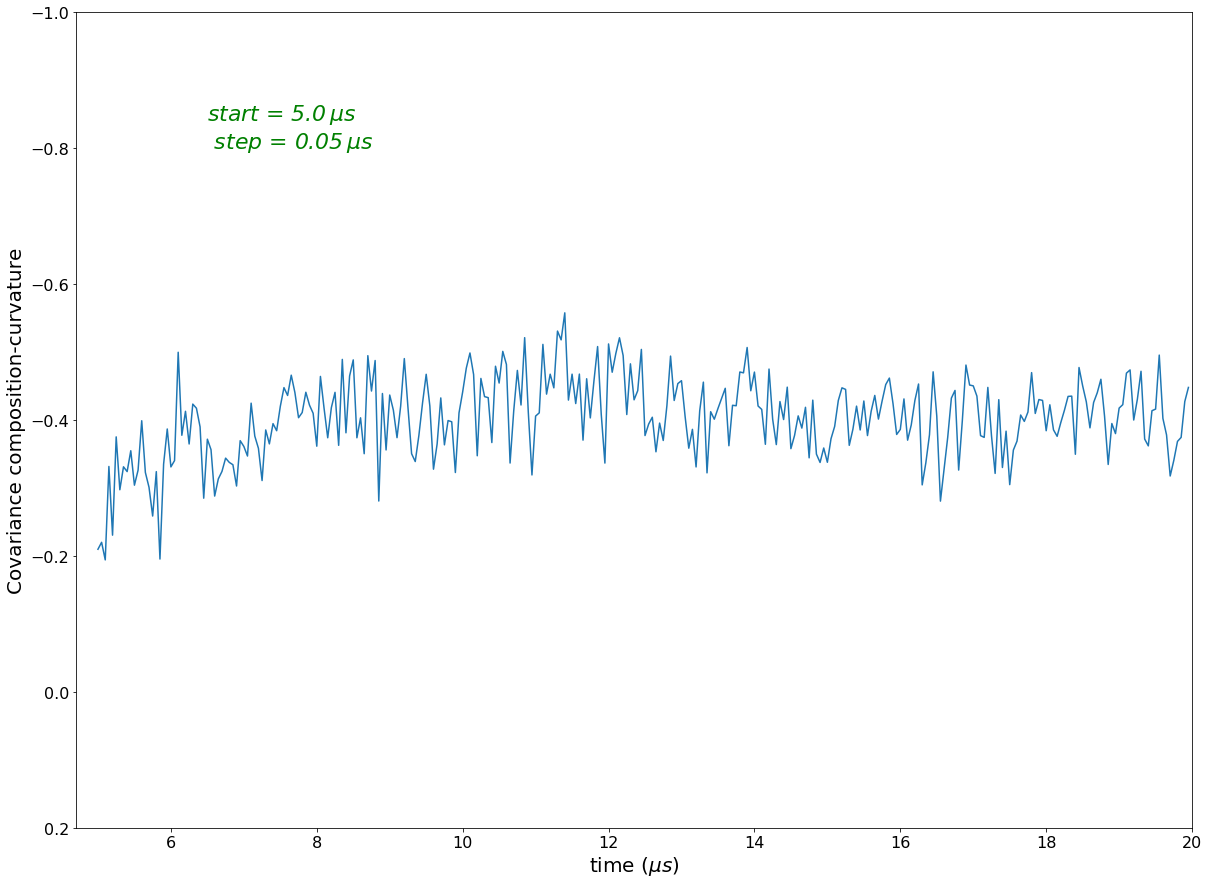

In [59]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(t, cov_c_t)

yprint = -0.8

plt.xlabel('time ($\mu s$)',fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Covariance composition-curvature',fontsize=20)
plt.yticks(fontsize=16)
plt.annotate('start = %.1lf$\, \mu s$\n step = %.2lf$\, \mu s$' % (t_start, tmes), color='g', fontsize=22, style='italic', xy=(xprint,yprint), xytext=(xprint,yprint))

xmin = t_start-0.3
xmax = time_simu
plt.xlim(xmin,xmax)
plt.ylim(0.2,-1)

plt.savefig(pathd+'cov_c_time_bin'+name+'.pdf', format='pdf',bbox_inches='tight')

In [60]:
xprint = min(t)+max(t)/10

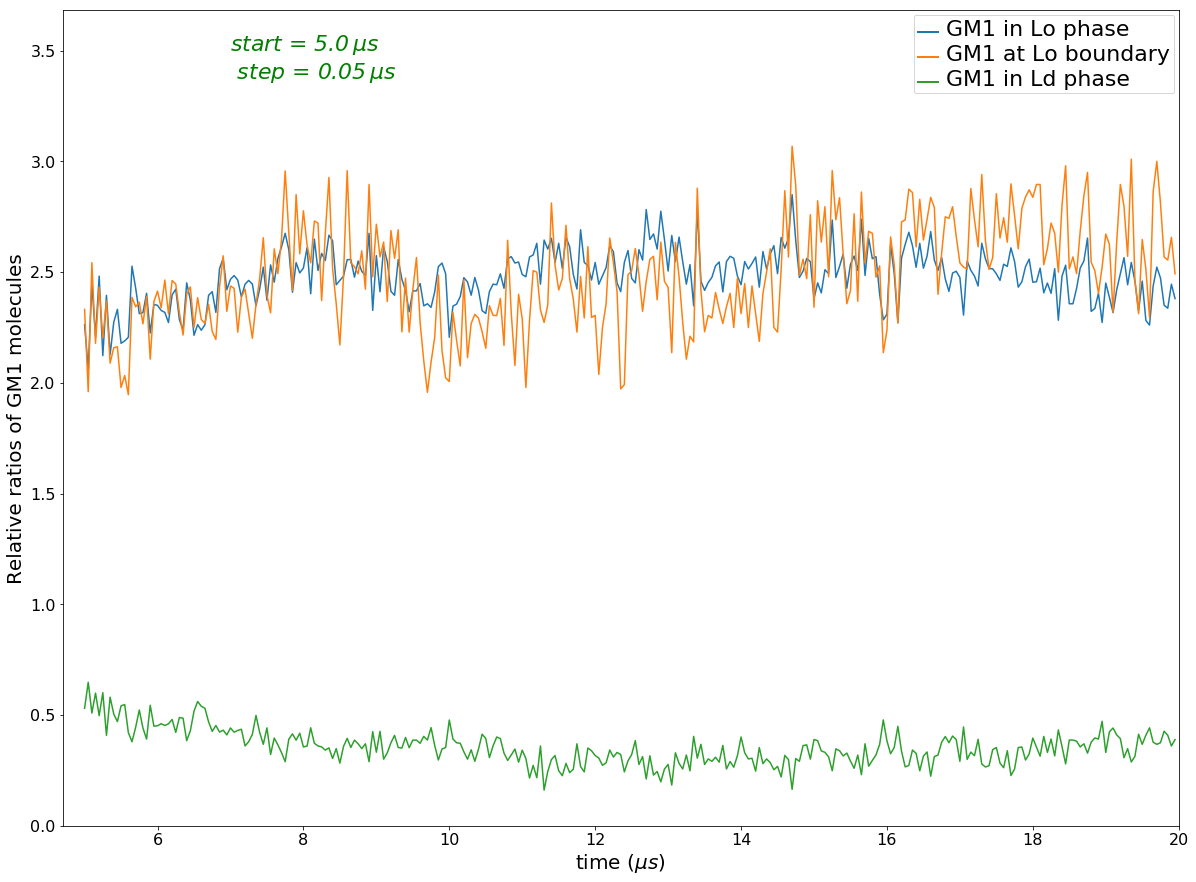

In [61]:
# Relative ratios of GM1 molecules (weighted by the area ratio)

if(len(GM1)!=0):
    fig, ax = plt.subplots(figsize=(20, 15))

    ax.plot(t, rate_GM1_Lo_t, label = 'GM1 in Lo phase')
    ax.plot(t, rate_GM1_bound_Lo_t, label = 'GM1 at Lo boundary')
    ax.plot(t, rate_GM1_Ld_t, label = 'GM1 in Ld phase')

    ytop = max(max(rate_GM1_bound_Lo_t),max(rate_GM1_Lo_t)) + max(max(rate_GM1_bound_Lo_t, rate_GM1_bound_Lo_t))/5

    yprint = ytop-max(max(rate_GM1_bound_Lo_t, rate_GM1_bound_Lo_t))/10

    plt.xlabel('time ($\mu s$)',fontsize=20)
    plt.xticks(fontsize=16)
    plt.ylabel('Relative ratios of GM1 molecules',fontsize=20)
    plt.yticks(fontsize=16)
    plt.annotate('start = %.1lf$\, \mu s$\n step = %.2lf$\, \mu s$' % (t_start, tmes), color='g', fontsize=22, style='italic', xy=(xprint,yprint), xytext=(xprint,yprint))

    legend = ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
    # The frame is matplotlib.patches.Rectangle instance surrounding the legend.
    frame = legend.get_frame()
    #frame.set_facecolor('0.90')
    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize(22)
    for label in legend.get_lines():
        label.set_linewidth(2)  # the legend line width


    xmin = t_start-0.3
    xmax = time_simu
    plt.xlim(xmin,xmax)
    ymin = 0
    plt.ylim(ymin,ytop)
    #plt.grid(True)

    plt.savefig(pathd+'GM1_ratios_time'+name+'.pdf', format='pdf',bbox_inches='tight')